## Learning about the TAD boundaries and domain sizes

#### - The source of the TAD input file is this paper: http://www.sciencedirect.com/science/article/pii/S2211124716314814 (Table S3). 
#### - The hg19.gaps.txt is downloaded from hgdownload.cse.ucsc.edu/goldenPath/hg19/database/gap.txt.gz, and slightly processed (sorted and removed one field).
#### - Note that while merging the TAD boundaries later, we will only consider those that are present in at least 20 % of the cell types (i.e. >= 4 out of 21) from this paper.
#### - Also, telomere regions and centromere-containing TADs are eventually thrown out. 
#### - chr17 assembly gap info is missing from the gap file. Similarly, chrY TAD info is missing in the file from the paper. Both of these chromosomes are treated as other chromosomes and telo-/centro-meres are removed as in other chromosomes.

In [1]:
xl_inputFile = "schmitt_etal_cell2016.xlsx" # x1 = excel
hg19_gapFile = "hg19.gaps.txt"  # Some info about the fields in this file is here: https://www.biostars.org/p/59749/ 
chr17_size = 81195210  # obtained from hg19.chromSizes.txt; hg19.gaps.txt doesn't have chr17 info
chrY_size = 59373566  # x1 tad input file does not have chrY info. The whole of chrY minus telomeres and centromeres (i.e. 2 TAD domains) will be designated as chrY TAD domains.
num_celltypes_tad_boundary_threshold = 4 # if merged TAD boundary is present in at least this many number of cell types, then the TAD boundary is considered. (others are ignored)

In [2]:
import pandas as pd
import numpy as np
from pybedtools import BedTool as bedtools
# column names in bedtools object are by default, chrom, start, stop, name, score and strand.

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%matplotlib inline
plt.rcParams['figure.figsize']=(12.0, 5.0)    #(6.0,4.0)
plt.rcParams['font.size']=12               #10 
plt.rcParams['savefig.dpi']=100             #72 
plt.rcParams['figure.subplot.bottom']=0.1  

In [3]:
'''Load all the TAD boundaries from all cell lines. 
dfs here is a dict of dfs - one for each cell line.'''
dfs_dict_tadboundaries = pd.read_excel(xl_inputFile, sheetname=None, header=None, names=["chr", "ss", "es"]) # dfs is a dict {cellline:df}

In [4]:
dfs_dict_tadboundaries.keys()

[u'GM12878',
 u'H1',
 u'IMR90',
 u'MES',
 u'MSC',
 u'NPC',
 u'TRO',
 u'AD',
 u'AO',
 u'BL',
 u'CO',
 u'HC',
 u'LG',
 u'LI',
 u'LV',
 u'OV',
 u'PA',
 u'PO',
 u'RV',
 u'SB',
 u'SX']

In [5]:
dfs_dict_tadboundaries["IMR90"].head(3)

,chr,ss,es
0,chr10,4880000,4920000
1,chr10,6040000,6080000
2,chr10,6440000,6480000


In [6]:
imr90_tads = bedtools.from_dataframe(dfs_dict_tadboundaries["IMR90"]).sort()
print("There is a total of {} IMR90 TAD boundaries.".format(imr90_tads.count()))

There is a total of 2231 IMR90 TAD boundaries.


In [7]:
'''Concatenate all the tad domains to study their properties together'''
all_tads_frames = [] 
for acellline in dfs_dict_tadboundaries.keys():
    all_tads_frames.append( dfs_dict_tadboundaries[acellline] )
df_all_tad_boundaries_beforeMerging = pd.concat(all_tads_frames) # note this is not sorted

print(df_all_tad_boundaries_beforeMerging.shape)

(47168, 3)


In [8]:
'''Now sort and merge the TAD domains'''
total_num_tads = bedtools.from_dataframe(df_all_tad_boundaries_beforeMerging).sort().saveas("all_tad_boundaries_beforeMerging.bed").merge().count()
print("There are a total of ", total_num_tads, " merged TAD boundaries in these cell lines.")

('There are a total of ', 5870, ' merged TAD boundaries in these cell lines.')


In [9]:
'''Also sorting the original df '''
df_all_tad_boundaries_beforeMerging.sort_values(by=["chr", "ss"], ascending=True, inplace=True)
'''And renaming the columns'''
df_all_tad_boundaries_beforeMerging.rename(columns=dict(zip(df_all_tad_boundaries_beforeMerging.columns, ['chrom', 'start', 'stop'])), inplace=True)
print(df_all_tad_boundaries_beforeMerging.shape)
df_all_tad_boundaries_beforeMerging.head(2)

(47168, 3)


,chrom,start,stop
716,chr1,2400000,2440000
733,chr1,2560000,2600000


In [10]:
'''Note that all tad boundaries are of size 40kb'''
set(df_all_tad_boundaries_beforeMerging["stop"] - df_all_tad_boundaries_beforeMerging["start"])

{40000}

## Plot sizes of the tad domains before merging the TAD boundaries

In [11]:
'''Compute the TAD sizes'''
df_all_tad_boundaries_beforeMerging["mid"] = (df_all_tad_boundaries_beforeMerging["stop"] + df_all_tad_boundaries_beforeMerging["start"])/2

tad_domain_sizes = [] # note: this has to be chromosome specific
for thisChr in set(df_all_tad_boundaries_beforeMerging["chrom"]):
    df_all_tads_thisChr = df_all_tad_boundaries_beforeMerging[df_all_tad_boundaries_beforeMerging["chrom"] == thisChr]
    tad_boundary_mids = df_all_tads_thisChr["mid"].tolist()
    tad_domain_sizes += [tad_boundary_mids[i+1] - tad_boundary_mids[i] for i in range(0, len(tad_boundary_mids)-1)]

print("Total number of TAD domains:", len(tad_domain_sizes))
print("There is a total of ", len([x for x in tad_domain_sizes if x > 1000000]), " TAD domains over 1mb")
print("There is a total of ", len([x for x in tad_domain_sizes if x > 2000000]), " TAD domains over 2mb")

('Total number of TAD domains:', 47145)
('There is a total of ', 502, ' TAD domains over 1mb')
('There is a total of ', 29, ' TAD domains over 2mb')


In [12]:
# Note the TAD boundaries are not merged Yet. So, a lot of "0.0 bp" TAD domain sizes 
# are expected, which is misleading, and should be removed for pre-merging analyses.
nz_tad_domain_sizes = [x for x in tad_domain_sizes if x > 0]
print("There's a total of {} non-zero unmerged TAD domains.".format(len(nz_tad_domain_sizes)))

There's a total of 16725 non-zero unmerged TAD domains.


Text(0,0.5,u'Density')

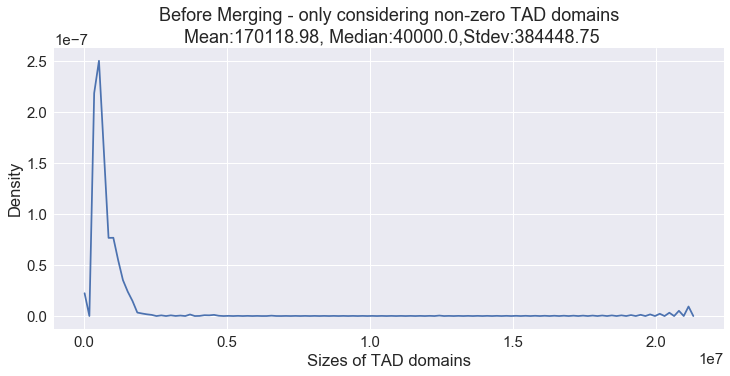

In [13]:
'''Plot the statistics of TAD sizes'''
avg_size = np.mean(nz_tad_domain_sizes)
med_size = np.median(nz_tad_domain_sizes)
std_size = np.std(nz_tad_domain_sizes)

sns.kdeplot(np.array(nz_tad_domain_sizes))
title = "Before Merging - only considering non-zero TAD domains\n Mean:{}, Median:{},\
Stdev:{}".format(round(avg_size,2), round(med_size, 2), round(std_size,2))
plt.title(title)
plt.xlabel("Sizes of TAD domains")
plt.ylabel("Density")

#### Note that the median size of 40kb suggests that a lot of TAD boundaries are adjacent/abutting each other across the cell types. (These will be merged by default "-d 0" mergeBed option later.)

## Plot sizes of the tad domains after merging the TAD boundaries
#### Note, here we will merge overlapping or abutting TAD boundaries. Additionally, we will only consider those merged boundaries that are present in at least 20% (>= 4 out of 21) of the cell types.

In [14]:
'''Generate a bed list of merged tad boundaries'''
bed_all_tad_boundaries_merged = bedtools.from_dataframe(df_all_tad_boundaries_beforeMerging[["chrom", "start", "stop", "mid"]]).sort().merge(c=1, o="count").saveas("all_tad_boundaries_afterMerging_notFiltdByN.bed")
print("There's a total of {} merged tad boundaries".format(bed_all_tad_boundaries_merged.count()))
bed_all_tad_boundaries_merged.head(3)  # Note the peak-mid column gets ignored by mergeBed.

There's a total of 5870 merged tad boundaries
chr1	2400000	2440000	1
 chr1	2560000	2600000	1
 chr1	3320000	3600000	13
 

In [15]:
'''Convert it to merged tad boundary df'''
df_all_tad_boundaries_merged = pd.read_table(bed_all_tad_boundaries_merged.fn, names=["chrom", "start", "stop", "count"]) 
df_all_tad_boundaries_merged_filtdByN = df_all_tad_boundaries_merged[df_all_tad_boundaries_merged["count"]>=num_celltypes_tad_boundary_threshold]
print("After filtering by the number of cell types with boundaries merged, there is a total of \
{} merged tad boundaries.".format(df_all_tad_boundaries_merged_filtdByN.shape[0]))
df_all_tad_boundaries_merged_filtdByN.head(2)

After filtering by the number of cell types with boundaries merged, there is a total of 3081 merged tad boundaries.


,chrom,start,stop,count
2,chr1,3320000,3600000,13
3,chr1,3640000,3800000,6


#### Note that the number of TAD boundaries has decreased by about 2000 after filtering by N (or count) of cell types with boundaries merged, suggesting the TAD domains will be larger on average.

In [16]:
df_all_tad_boundaries_merged_filtdByN["mid"] = (df_all_tad_boundaries_merged_filtdByN["stop"] + df_all_tad_boundaries_merged_filtdByN["start"])/2

tad_sizes_merged = [] # note: this has to be chromosome specific
for thisChr in set(df_all_tad_boundaries_merged_filtdByN["chrom"]):
    df_all_tads_merged_thisChr = df_all_tad_boundaries_merged_filtdByN[df_all_tad_boundaries_merged_filtdByN["chrom"] == thisChr]
    tad_mids = df_all_tads_merged_thisChr["mid"].tolist()
    tad_sizes_merged += [tad_mids[i+1] - tad_mids[i] for i in range(0, len(tad_mids)-1)]

print("Total number of TAD domains:{}. This is 23 less than total number of TAD boundaries.".format(len(tad_sizes_merged)))
print("There is a total of ", len([x for x in tad_sizes_merged if x > 1000000]), " TAD domains over 1mb")
print("There is a total of ", len([x for x in tad_sizes_merged if x > 2000000]), " TAD domains over 2mb")

Total number of TAD domains:3058. This is 23 less than total number of TAD boundaries.
('There is a total of ', 1062, ' TAD domains over 1mb')
('There is a total of ', 141, ' TAD domains over 2mb')


/Users/Dinesh/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0,0.5,u'Density')

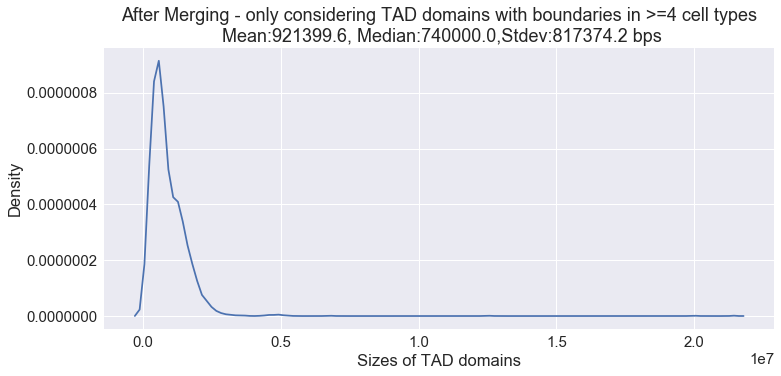

In [17]:
avg_size_merged = np.mean(tad_sizes_merged)
med_size_merged = np.median(tad_sizes_merged)
std_size_merged = np.std(tad_sizes_merged)

sns.kdeplot(np.array(tad_sizes_merged))
title = "After Merging - only considering TAD domains with boundaries in >={} cell types\n Mean:{}, Median:{},\
Stdev:{} bps".format(num_celltypes_tad_boundary_threshold, round(avg_size_merged,1), round(med_size_merged, 1), round(std_size_merged,1))
plt.title(title)
plt.xlabel("Sizes of TAD domains")
plt.ylabel("Density")

## Now generate a TAD domain bed file (for merged TADs - also filtered by number of cell types with the TAD boundaries). 
** This will be used downstream to look for genes present in any given TAD.**

In [18]:
'''First get the telomere locations from the hg19.gaps.txt'''
df_hg19_gaps = pd.read_csv(hg19_gapFile, sep="\t", header=None)
df_hg19_gaps.columns = ["chrom", "start", "end", "n", "len", "type", "bridge"]
df_hg19_gaps.head()

,chrom,start,end,n,len,type,bridge
0,chr1,0,10000,N,10000,telomere,no
1,chr1,177417,227417,N,50000,clone,yes
2,chr1,267719,317719,N,50000,contig,no
3,chr1,471368,521368,N,50000,contig,no
4,chr1,2634220,2684220,N,50000,clone,yes


In [19]:
'''generate a TAD domain bed file. Also add the first and last TAD domains (subtracting the telomere regions)'''

df_tads_frames = [] # a list of df_tads for chromosomes

for thisChr in set(df_all_tad_boundaries_merged["chrom"]):
    df_tad_boundaries_x = df_all_tad_boundaries_merged_filtdByN[df_all_tad_boundaries_merged_filtdByN["chrom"] == thisChr]
    tads_x = [[thisChr, int(list(df_tad_boundaries_x["mid"])[i-1]), int(list(df_tad_boundaries_x["mid"])[i])] for i in range(1, df_tad_boundaries_x.shape[0])]

    # add the first and the last TAD domains (minus telomeres)
    tads_x = [[thisChr, 10000, tads_x[0][1]]] + tads_x  # adding the first TAD domain (10kb b/c 0-10kb is telemore for all chroms)
    try:
        last_boundary_x = int(df_hg19_gaps[(df_hg19_gaps["type"] == "telomere") &
                    (df_hg19_gaps["chrom"] == thisChr) &
                    (df_hg19_gaps["start"] > 0)]["start"])
    except:
        assert thisChr == "chr17"  # chr17 info is not in the hg19.gaps.txt
        last_boundary_x = chr17_size - 10000
    if (tads_x[-1][-1] < last_boundary_x):
        tads_x += [[thisChr, tads_x[-1][-1], last_boundary_x]]  # adding the last TAD domain
    else:
        print("Shrinking the last TAD for {} to remove telomere".format(thisChr))
        tads_x[-1][-2] < last_boundary_x
        tads_x[-1][-1] = last_boundary_x

    df_tads_x = pd.DataFrame.from_records(tads_x, columns = ["chrom", "start", "stop"])
    df_tads_frames.append(df_tads_x)

# chrY is not accounted for yet. 
df_tads_x = pd.DataFrame.from_records([["chrY", 10000, chrY_size-10000]], columns = ["chrom", "start", "stop"])
df_tads_frames.append(df_tads_x)

df_tads = pd.concat(df_tads_frames)

In [20]:
print(df_tads.shape)
df_tads.head(2)

(3105, 3)


,chrom,start,stop
0,chrX,10000,5900000
1,chrX,5900000,6120000


### Removing those TADs that overlap centromeres. 

In [21]:
df_gaps_hg19_centr = df_hg19_gaps[(df_hg19_gaps["type"] == "centromere")]

# selecting TADs that don't overlap the centromeres
bed_tads_nogaps = bedtools.from_dataframe(df_tads).intersect(bedtools.from_dataframe(df_gaps_hg19_centr), v=True).sort()
print("There is a total of {} TAD domains that do not overlap the centromeres. \
Note that this is exactly the total number of TADs so far minus the total number\
of chromosomes (including chrY) ".format(bed_tads_nogaps.count()))

There is a total of 3081 TAD domains that do not overlap the centromeres. Note that this is exactly the total number of TADs so far minus the total numberof chromosomes (including chrY) 


## Save the tad domain bed file, and plot the final distribution of TAD domain lengths.

Text(0,0.5,u'Density')

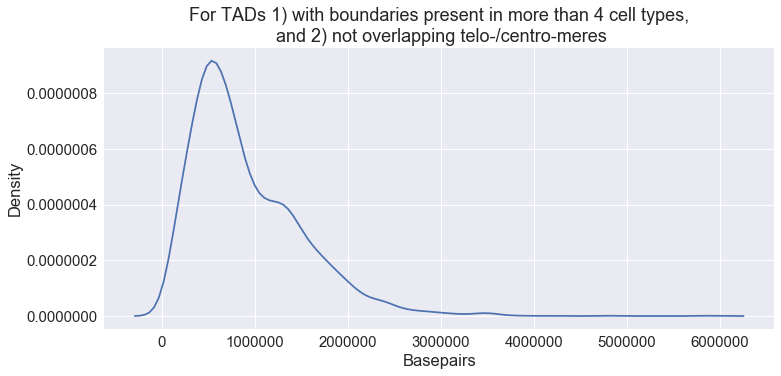

In [22]:
bed_tads_nogaps.saveas("tad_domains_nIs{}celltypes_noCentrTelo.bed".format(num_celltypes_tad_boundary_threshold))

df_tads_nogaps = pd.read_table(bed_tads_nogaps.fn, names=["chrom", "start", "stop"]) # note: "no_gaps" only mean no centr and no telo
tad_domain_sizes = df_tads_nogaps["stop"] - df_tads_nogaps["start"]

sns.kdeplot(np.array(tad_domain_sizes))
plt.title("For TADs 1) with boundaries present in more than {} cell types,\n and 2) not overlapping telo-/centro-meres".format(num_celltypes_tad_boundary_threshold)) 
plt.xlabel("Basepairs")
plt.ylabel("Density")

In [23]:
### - EOF - 